# This Notebook Explores Computer Vision Using MNIST Dataset.

In [1]:
# Required libraries are loaded. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [2]:
# Files to be used.
path = "../../../Data/digit-recognizer/"
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


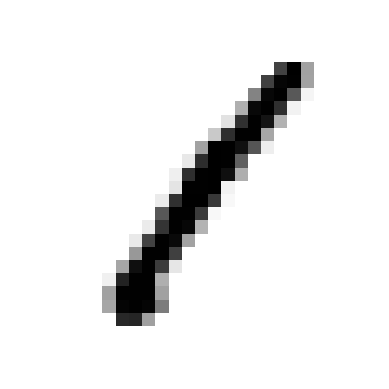

In [5]:
# Here we are visualizing a sample observation.
obs = train.iloc[0,][1:].to_numpy()
im = obs.reshape(28, 28)
plt.imshow(im, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
# Working with numpy is easier on sklearn.
X_train = train.loc[:,"pixel0":].to_numpy()
y_train = train.loc[:,"label"].to_numpy()
test = test.to_numpy()

### Data Augmentation

In [38]:
from scipy.ndimage import shift

In [ ]:
def data_augmentation(data):
    """
    This function shifts an image (up, down, left, right) then adds the shifts to the training data.
    """
    for index in range(len(data)):
        # Reshapes as the image is a 28 x 28 pixels.
        image = data[[index]].reshape(28, 28)
        
        # Shifts the image in the four directions.
        image_shifted_down = shift(image, [1, 0], cval=0)
        image_shifted_up = shift(image, [-1, 0], cval=0)
        image_shifted_right = shift(image, [0, 1], cval=0)
        image_shifted_left = shift(image, [0, -1], cval=0)
        
        # Reshapes back to 784 features.
        image_shifted_down = image_shifted_down.reshape(1,784)
        image_shifted_up = image_shifted_up.reshape(1,784)
        image_shifted_right = image_shifted_right.reshape(1,784)
        image_shifted_left = image_shifted_left.reshape(1,784)
        
        # Concatenate to original training data.
        np.concatenate((data, image_shifted_down), axis=0)
        np.concatenate((data, image_shifted_up), axis=0)
        np.concatenate((data, image_shifted_right), axis=0)
        np.concatenate((data, image_shifted_left), axis=0)
    return data

X_train_augmentated = data_augmentation(X_train)

In [ ]:
print(X_train.shape)
print(X_train_augmentated.shape)

After building sgd, naive bayes, random forest and kneighbors, the latter two are the most promising.
Random Forest is taking forever to train so will just work with kneighbors.

The best kneighbors parameters to use are n_neighbors=4 and weights=distance (used grid search)

In [ ]:
# Building model using best parameters and augmentated data.
knn_clf = KNeighborsClassifier(n_neighbors=4, weights="distance")
knn_clf.fit(X_train_augmentated, y_train)

In [ ]:
knn_preds = knn_clf.predict(test)

In [ ]:
df = pd.DataFrame()
df["ImageId"] = np.arange(1, 28001)
df["Label"] = knn_preds
df.to_csv("kneighbors_predictions.csv", index=False)

In [35]:
X_train_augmented = [image for image in X_train]

In [39]:
len(X_train_augmented)

42000

In [41]:
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    print(dx)

1
-1
0
0
